Response Statistics per Endpoint:
                      average_response_time  p95_response_time
endpoint                                                      
/api/chat                        445.026515             235.65
/api/recommendations             348.311871             155.20
/api/search                      471.608081             157.90
/api/user/profile                410.600806             160.00

Error Rates:
500    42.622951
400    40.983607
504    16.393443
Name: status_code, dtype: float64

Peak Usage:
          date  hour  requests
84  2024-12-05    11        12

Percentage of Requests > 1s: 0.99%


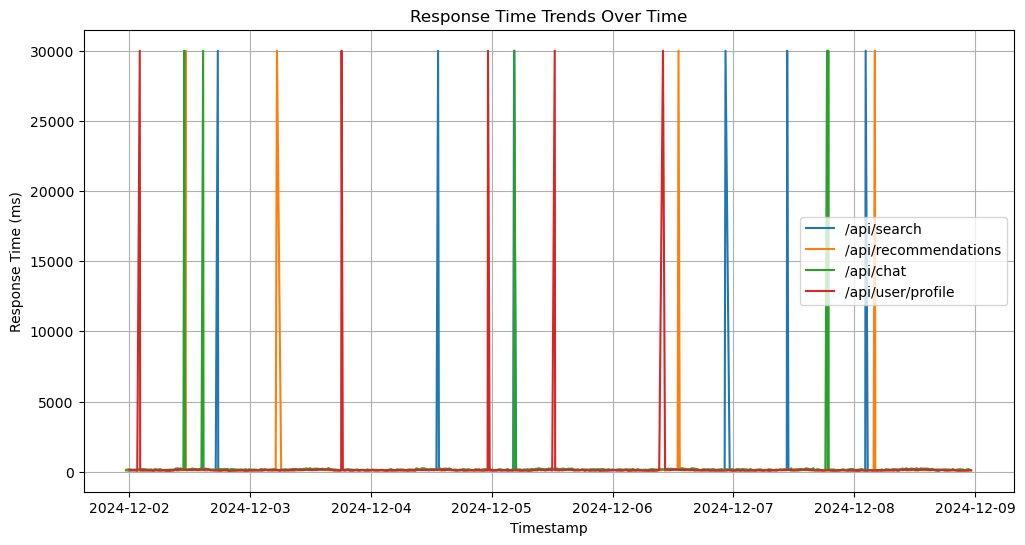

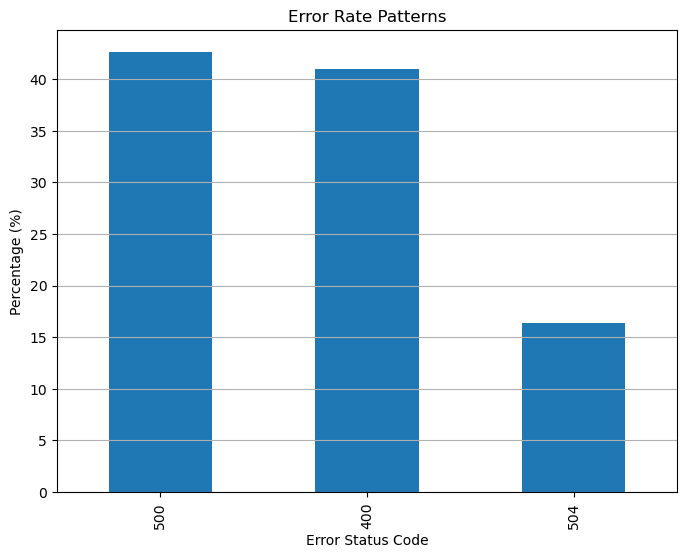

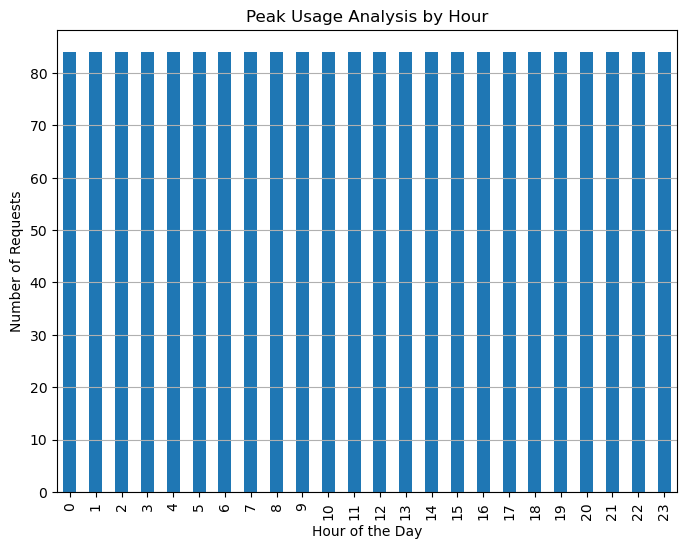


Response Time Anomalies:
               timestamp              endpoint  user_id  response_time_ms  \
33   2024-12-02 02:05:31     /api/user/profile  user_18             30000   
139  2024-12-02 10:55:31             /api/chat   user_6             30000   
142  2024-12-02 11:10:31  /api/recommendations  user_54             30000   
184  2024-12-02 14:40:31             /api/chat  user_88             30000   
219  2024-12-02 17:35:31           /api/search  user_40             30000   
360  2024-12-03 05:20:31  /api/recommendations  user_38             30000   
514  2024-12-03 18:10:31     /api/user/profile  user_53             30000   
744  2024-12-04 13:20:31           /api/search  user_82             30000   
863  2024-12-04 23:15:31     /api/user/profile  user_13             30000   
925  2024-12-05 04:25:31           /api/search  user_18             30000   
926  2024-12-05 04:30:31             /api/chat  user_67             30000   
1022 2024-12-05 12:30:31     /api/user/profile  us

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = 'C:\\Users\\DELL\\Downloads\\Copy of app_logs.xlsx' 
app_logs = pd.read_excel(file_path)

app_logs['timestamp'] = pd.to_datetime(app_logs['timestamp'])

app_logs['date'] = app_logs['timestamp'].dt.date
app_logs['hour'] = app_logs['timestamp'].dt.hour

def calculate_metrics(logs):
    # Average and P95 response times per endpoint
    response_stats = logs.groupby('endpoint')['response_time_ms'].agg(
        average_response_time='mean',
        p95_response_time=lambda x: x.quantile(0.95)
    )

    # Error rates and types of errors
    total_requests = logs['endpoint'].count()
    error_logs = logs[logs['status_code'] >= 400]
    error_rates = error_logs['status_code'].value_counts(normalize=True) * 100

    # Peak usage periods (hourly aggregation)
    usage_peak = logs.groupby(['date', 'hour']).size().reset_index(name='requests').sort_values(by='requests', ascending=False).head(1)

    # User experience metrics: % of requests > 1s
    long_responses = len(logs[logs['response_time_ms'] > 1000]) / total_requests * 100

    return {
        "response_stats": response_stats,
        "error_rates": error_rates,
        "peak_usage": usage_peak,
        "long_responses_percent": long_responses
    }

# Anomaly Detection
def detect_anomalies(logs):
    response_mean = logs['response_time_ms'].mean()
    response_std = logs['response_time_ms'].std()

    anomalies = logs[logs['response_time_ms'] > response_mean + 3 * response_std]
    
    # Error rate anomalies
    error_anomalies = logs[logs['status_code'] >= 500]
    
    # Endpoint availability issues (any hour with zero requests)
    hourly_requests = logs.groupby(['date', 'hour']).size()
    availability_issues = hourly_requests[hourly_requests == 0]

    return {
        "response_time_anomalies": anomalies,
        "error_anomalies": error_anomalies,
        "availability_issues": availability_issues
    }

# Calculating metrics
metrics = calculate_metrics(app_logs)
response_stats = metrics['response_stats']
error_rates = metrics['error_rates']
peak_usage = metrics['peak_usage']
long_responses_percent = metrics['long_responses_percent']

print("Response Statistics per Endpoint:")
print(response_stats)
print("\nError Rates:")
print(error_rates)
print("\nPeak Usage:")
print(peak_usage)
print(f"\nPercentage of Requests > 1s: {long_responses_percent:.2f}%")

# Visualization: Response time trends over time
plt.figure(figsize=(12, 6))
for endpoint in app_logs['endpoint'].unique():
    subset = app_logs[app_logs['endpoint'] == endpoint]
    plt.plot(subset['timestamp'], subset['response_time_ms'], label=endpoint)

plt.title('Response Time Trends Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Response Time (ms)')
plt.legend()
plt.grid(True)
plt.show()

# Visualization: Error rate patterns
if not error_rates.empty:
    error_rates.plot(kind='bar', figsize=(8, 6), title='Error Rate Patterns')
    plt.ylabel('Percentage (%)')
    plt.xlabel('Error Status Code')
    plt.grid(axis='y')
    plt.show()

# Visualization: Peak usage analysis
plt.figure(figsize=(8, 6))
peak_usage_hourly = app_logs.groupby(['hour']).size()
peak_usage_hourly.plot(kind='bar', title='Peak Usage Analysis by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Requests')
plt.grid(axis='y')
plt.show()

# Anomaly detection
anomalies = detect_anomalies(app_logs)
response_time_anomalies = anomalies['response_time_anomalies']
error_anomalies = anomalies['error_anomalies']

# Print anomalies for review
print("\nResponse Time Anomalies:")
print(response_time_anomalies)
print("\nError Anomalies:")
print(error_anomalies)
